In [1]:
import pandas as pd
import os, sys
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from utils.prediction_utils import *

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

import xgboost as xgb

random_seed = 42

In [2]:
base_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling"
X, y = get_data("conv2d", base_dir, sample_rate=1.0)
X.info()

34it [00:20,  1.01s/it]

< 0 found in file time.32.1024.0.pkl


44it [00:30,  1.03it/s]

< 0 found in file time.128.512.0.pkl


46it [00:32,  1.01s/it]

< 0 found in file time.128.1024.0.pkl


54it [00:40,  1.08it/s]

< 0 found in file time.512.128.0.pkl


56it [00:43,  1.32s/it]

< 0 found in file time.512.512.0.pkl


58it [00:46,  1.35s/it]

< 0 found in file time.512.1024.0.pkl


59it [00:48,  1.55s/it]

< 0 found in file time.512.1024.1.pkl


64it [00:51,  1.24it/s]

< 0 found in file time.1024.32.0.pkl


66it [00:54,  1.09it/s]

< 0 found in file time.1024.128.0.pkl


68it [00:56,  1.00it/s]

< 0 found in file time.1024.512.0.pkl


69it [00:58,  1.24s/it]

< 0 found in file time.1024.512.1.pkl


70it [00:58,  1.03s/it]

< 0 found in file time.1024.1024.0.pkl


71it [01:00,  1.26s/it]

< 0 found in file time.1024.1024.1.pkl


72it [01:01,  1.17it/s]
/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/utils/time_utils.py:402: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfs = pd.concat(dfs, axis=0, ignore_index=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 685125 entries, 0 to 685124
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             685125 non-null  int64  
 1   in_channels   685125 non-null  int64  
 2   iH            685125 non-null  int64  
 3   iW            685125 non-null  int64  
 4   out_channels  685125 non-null  int64  
 5   groups        685125 non-null  int64  
 6   kH            685125 non-null  int64  
 7   kW            685125 non-null  int64  
 8   stride        685125 non-null  int64  
 9   dilation      685125 non-null  int64  
 10  oH            685125 non-null  int64  
 11  oW            685125 non-null  int64  
 12  gflops        685125 non-null  float64
 13  dtype_16      685125 non-null  bool   
 14  dtype_32      685125 non-null  bool   
 15  dtype_b16     685125 non-null  bool   
 16  transposed_0  685125 non-null  bool   
 17  transposed_1  685125 non-null  bool   
dtypes: b

In [3]:
df_orig = pd.concat([X, y], axis=1)
df = df_orig.copy()

In [4]:
df = df.query("time > 0").dropna()
df = df.query("gflops < 1e2")
X, y = df.drop(["time"], axis=1), df["time"]

<AxesSubplot:>

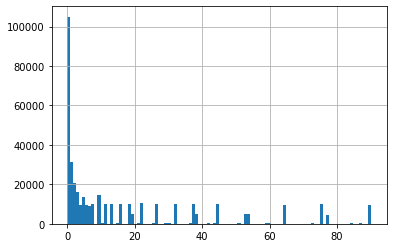

In [5]:
df["gflops"].hist(bins=100)

In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test_split(X, y, return_concat=False)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 273584 entries, 505465 to 144774
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   b             273584 non-null  int64  
 1   in_channels   273584 non-null  int64  
 2   iH            273584 non-null  int64  
 3   iW            273584 non-null  int64  
 4   out_channels  273584 non-null  int64  
 5   groups        273584 non-null  int64  
 6   kH            273584 non-null  int64  
 7   kW            273584 non-null  int64  
 8   stride        273584 non-null  int64  
 9   dilation      273584 non-null  int64  
 10  oH            273584 non-null  int64  
 11  oW            273584 non-null  int64  
 12  gflops        273584 non-null  float64
 13  dtype_16      273584 non-null  bool   
 14  dtype_32      273584 non-null  bool   
 15  dtype_b16     273584 non-null  bool   
 16  transposed_0  273584 non-null  bool   
 17  transposed_1  273584 non-null  bool   
dtypes: b

# Fitting

## Decision Tree

Train--------
Mean Squared Error: 6.578679949216749
MAPE: 0.05717256347838966
R-squared: 0.9602641327666944


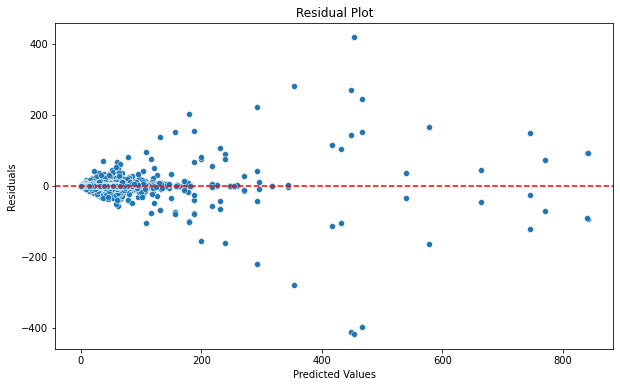

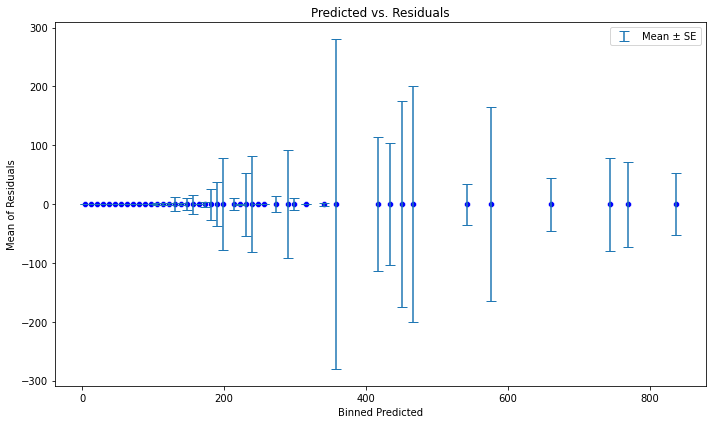

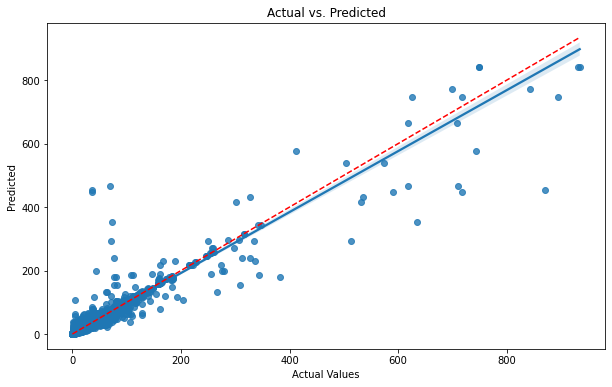

Val--------
Mean Squared Error: 69.65140304905674
MAPE: 0.12196271162640022
R-squared: 0.5770791969569407


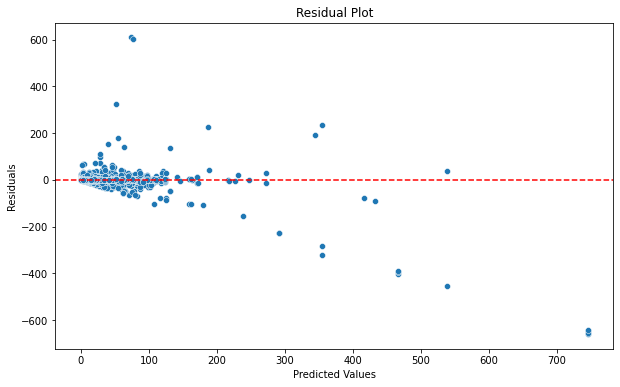

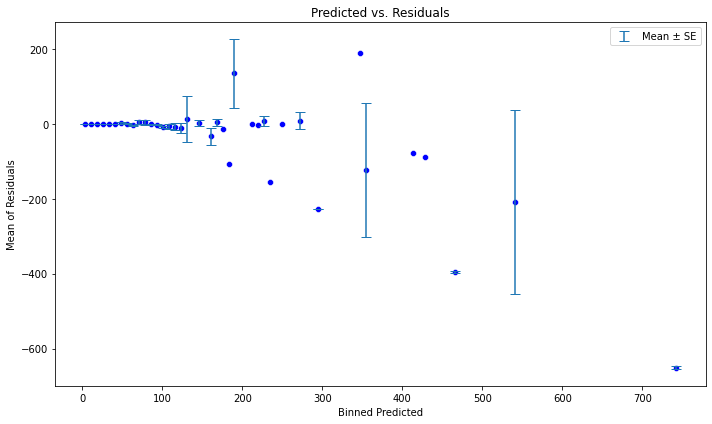

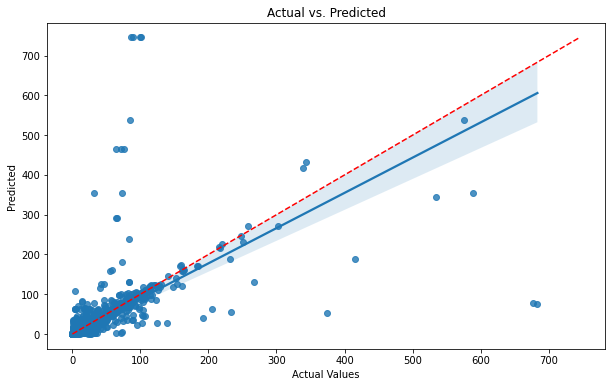

In [7]:
tree_model = DecisionTreeRegressor(max_depth=20, min_samples_split=2, min_samples_leaf=2, max_features=100, random_state=random_seed)
tree_model.fit(X_train, y_train)

y_hat_train = tree_model.predict(X_train)
y_hat_val = tree_model.predict(X_val)

y_train_res = y_hat_train - y_train

print("Train--------")
get_r2_score(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train)
plot_residuals(y_train, y_hat_train, bins=100)
plot_actual_vs_pred(y_train, y_hat_train)

print("Val--------")
get_r2_score(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val)
plot_residuals(y_val, y_hat_val, bins=100)
plot_actual_vs_pred(y_val, y_hat_val)

In [24]:
feature_importances = tree_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

features_df = features_df.sort_values(by='Importance', ascending=False)
features_df

,Feature,Importance
12,gflops,0.325746
5,groups,0.180194
4,out_channels,0.107728
1,in_channels,0.104415
0,b,0.051575
13,dtype_16,0.048247
7,kW,0.040237
14,dtype_32,0.034347
3,iW,0.021647
16,transposed_0,0.021006


# Save Model

In [8]:
# import pickle
# save_dir = os.path.join(base_dir, "final_models", "conv2d.pkl")
# with open(save_dir, 'wb') as f:
#     pickle.dump(tree_model, f)

import joblib
joblib.dump(tree_model, 'conv2d.joblib')

['conv2d.joblib']